Run after filtering

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn.cluster import KMeans
from importlib import reload
from tqdm.notebook import tqdm, trange

import utils
import hhclustering as hc
reload(utils)
reload(hc)

<module 'hhclustering' from 'C:\\Users\\jungyoung\\Desktop\\Project\\hh_neuralnet\\three_pop_mpi\\clustering\\hhclustering.py'>

In [2]:
def load_saved(fname):
    import os
    import pickle as pkl
    
    fdir = "../simulation_data"
    with open(os.path.join(fdir, fname), "rb") as fp:
        return pkl.load(fp)

In [3]:
pdata = load_saved("purified_data.pkl")

# Clustering

## Find proper K

In [4]:
with open("./data/kmeans_explore.pkl", "rb") as fp:
    kmeans_result = pkl.load(fp)
print(kmeans_result.keys())
num_clusters = [km[0].cluster_centers_.shape[0] for km in kmeans_result["km_obj_sets"]]

FileNotFoundError: [Errno 2] No such file or directory: './data/kmeans_explore.pkl'

save to ./fig/./clustering_performance_full_2023629.png


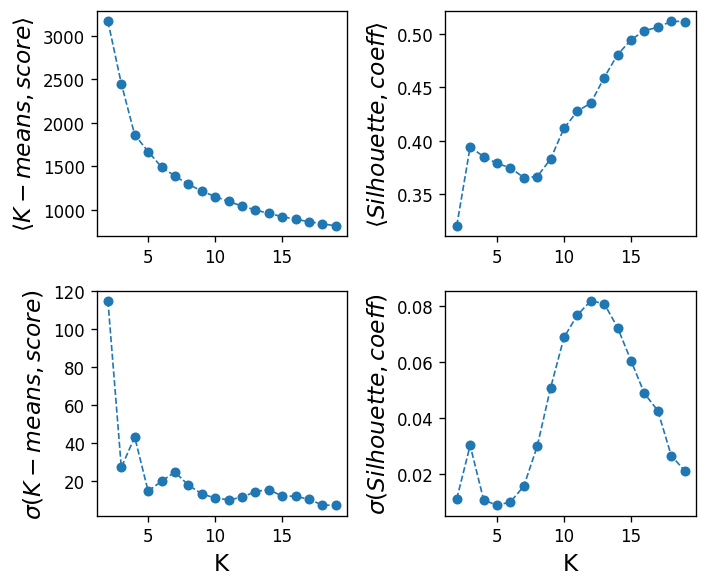

In [868]:
lbs = [[r"$\langle K-means, score \rangle$", r"$\langle Silhouette, coeff \rangle$"],
       [r"$\sigma(K-means, score)$", r"$\sigma(Silhouette,coeff)$"]]

plt.figure(figsize=(6, 5), dpi=120)
n = 1
for i, fn in enumerate([np.average, np.std]):
    for j, vname in enumerate(["kcoeff_sets", "scoeff_sets"]):
        plt.subplot(2, 2, n)
        plt.plot(num_clusters, fn(kmeans_result[vname], axis=1), '.--', lw=1, ms=10)
        n += 1
        
        if i ==1:
            plt.xlabel("K", fontsize=14)
        plt.ylabel(lbs[i][j], fontsize=14)
        
plt.tight_layout()
utils.save_fig("./clustering_performance_full")

plt.show()

save to ./fig/./clustering_performance_diff_full_2023629.png


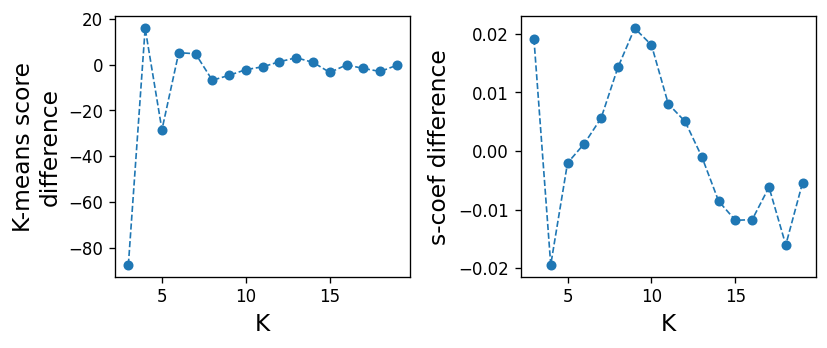

In [875]:
plt.figure(figsize=(7, 3), dpi=120)

plt.subplot(121)
y = fn(kmeans_result["kcoeff_sets"], axis=1)
plt.plot(num_clusters[1:], y[1:] - y[:-1], '.--', ms=10, lw=1)
plt.ylabel("K-means score\ndifference", fontsize=14)
plt.xlabel("K", fontsize=14)

plt.subplot(122)
y = fn(kmeans_result["scoeff_sets"], axis=1)
plt.plot(num_clusters[1:], y[1:] - y[:-1], '.--', ms=10, lw=1)
plt.ylabel("s-coef difference", fontsize=14)
plt.xlabel("K", fontsize=14)
utils.save_fig("./clustering_performance_diff_full")
plt.tight_layout()
plt.show()

## Robust clustering

### Check with probs

In [853]:
with open("./clustering.pkl", "rb") as fp:
    cluster_result = pkl.load(fp)
cluster_result.keys()

N = cluster_result["km_objs"][0].cluster_centers_.shape[0]

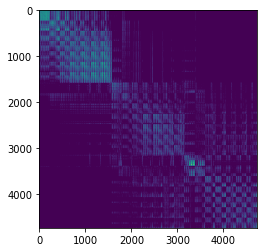

In [854]:
plt.figure(figsize=(4,4))
plt.imshow(cluster_result["same_prob"] > 0.8)
plt.show()

In [379]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=N, affinity="precomputed")
cluster_id = model.fit_predict(cluster_result["same_prob"])

In [402]:
# ordering
align_prob_mat = np.zeros_like(cluster_result["same_prob"])
n0 = 0
for n in np.unique(cluster_id):
    cin = np.where(cluster_id == n)[0]
    for i in range(len(cin)):
        align_prob_mat[n0+i, :] = cluster_result["same_prob"][cin[i], :]
        align_prob_mat[:, n0+i] = cluster_result["same_prob"][:, cin[i]]
    n0 += len(cin)

In [370]:
# Construct Laplacian matrix
D = np.zeros_like(cluster_result["same_prob"])
for i in range(cluster_result["same_prob"].shape[0]):
    D[i, i] = np.sum(cluster_result["same_prob"][i])
    
lmat = D - cluster_result["same_prob"]

In [ ]:
eigval, eigvec = np.linalg.eigh(cluster_result["same_prob"])

# sort
id_eig = np.argsort(eigval)[::-1]
eigval = eigval[id_eig]
eigvec = eigvec[:, id_eig]

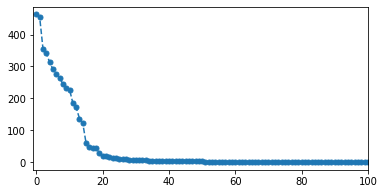

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(eigval, '.--', ms=10)
plt.xlim([-1, 100])
plt.show()

### Visualize the density

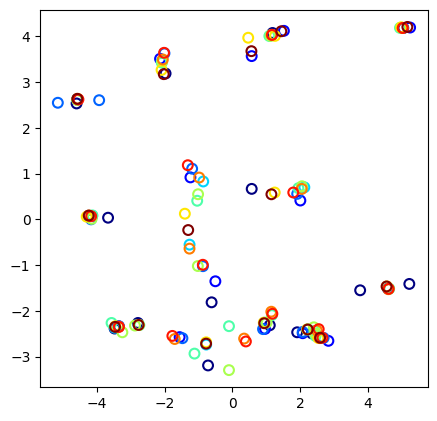

In [415]:
nc = 13

K = num_clusters[nc]
centers = [km_objs[nc][i].cluster_centers_ for i in range(nitr)]
centers_cat = np.concatenate(centers)

eigval, eigvec, pca_data, _ = hc.pca(centers_cat.T)
pcenters = pca_data.T @ eigvec[:, :2]

plt.figure(figsize=(5,5), dpi=100)
cmap = cmap = plt.get_cmap("jet", nitr)
for n in range(nitr):
    plt.scatter(pcenters[n*K:(n+1)*K, 0], pcenters[n*K:(n+1)*K, 1],
                s=50, facecolors="none", edgecolors=cmap(n/nitr), lw=1.5)
plt.show()

In [416]:
def distrib_map(points, dx=0.2, xstd=1, K=1):
    # points (N x ndim)
    N = points.shape[0]
    ndim = points.shape[1]
    
    # transform
    m0 = np.average(points, axis=0)
    s0 = np.std(points, axis=0)
    t_data = (points - m0[np.newaxis, :]) / s0[np.newaxis, :]
    
    # run PCA -> reduct to 2dim
    eigval, eigvec, pca_data, _ = hc.pca(t_data.T)
    reduced_data = t_data @ eigvec[:, :2]
    
    # set bd
    s = np.std(reduced_data, axis=0)
    bd = [np.min(reduced_data, axis=0)-s,
          np.max(reduced_data, axis=0)+s] # 2 x 2 matrix
    
    # make grid
    width = ((bd[1] - bd[0]) / dx).astype(int)+1
    w = max(width)
    x0 = np.linspace(bd[0][0], bd[1][0], w) # 1st ind, col
    x1 = np.linspace(bd[0][1], bd[1][1], w) # 2nd ind, row
    X0, X1 = np.meshgrid(x0, x1)
    grid = np.zeros([w, w]) # 2nd ind / 1st ind
    
    # run
    for n in range(N):
        r = reduced_data[n, :]
        grid += 1/xstd/np.sqrt(2*np.pi) * np.exp(-1/2 * ((X0-r[0])**2 + (X1-r[1])**2))
        
    # pick Kth peak
    tmp = grid.flatten()
    vals = np.sort(tmp)[::-1]
    h1, h0 = np.where(grid >= vals[K-1])
    
    # reconstruct points
    hpoints = np.array([h0[n] * eigvec[:, 0] + h1[n] * eigvec[:, 1] for n in range(K)])
    
    
    return grid, x0, x1, hpoints

In [417]:
grid, x, y, hpoints = distrib_map(centers_cat, K=K)

15


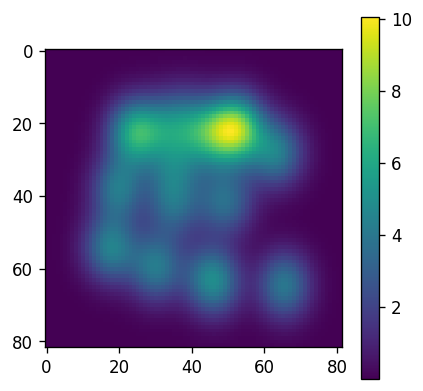

In [418]:
print(K)
plt.figure(dpi=120, figsize=(4,4))
plt.imshow(grid)
plt.colorbar()
# plt.plot(h0, h1, 'rp')
plt.show()

# clustering with K = 15 

15


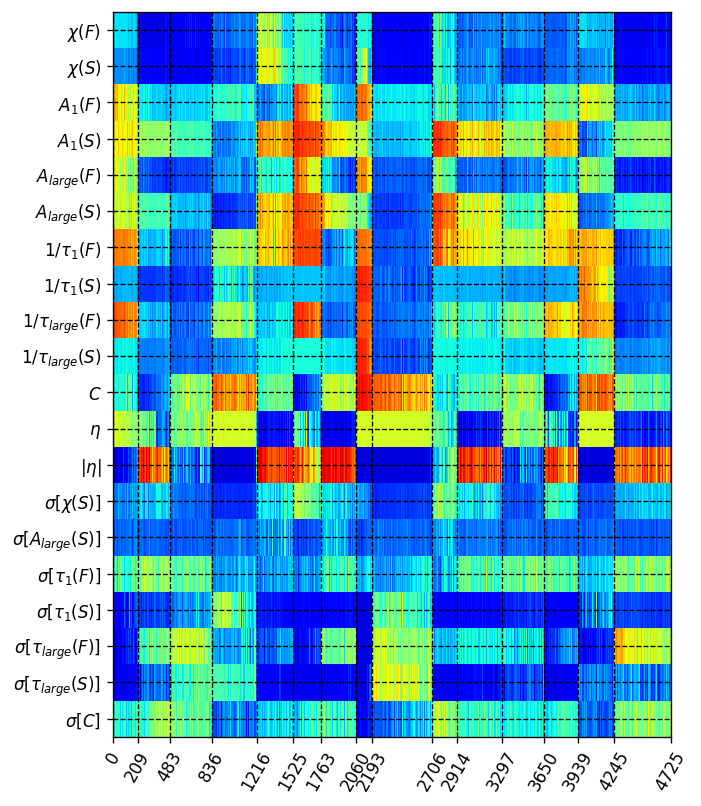

In [704]:
nc = 13

K = num_clusters[nc]
print(K)

id_itr = 4
cluster_id = km_objs[nc][id_itr].predict(pdata["data"].T)
reordered_data, id_sort, bds = hc.reorder_data(pdata["data"], cluster_id, sval_sets[nc][id_itr])

plt.figure(figsize=(6, 8), dpi=120)
s_data = hc.hsmooth(reordered_data)
plt.imshow(s_data, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(s_data.shape[0]), labels=pdata["row_labels"])
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

km_use = km_objs[nc][id_itr]

In [691]:
# Save representative points
loc_points = []
sval_points = []

edges = [0] + bds
for n in range(K):
    id_pts = id_sort[edges[n]:edges[n+1]]
    loc_points.append([])
    sval_points.append([])
    for nid in id_pts:
        tag = pdata["col_names"][int(nid)]
        nr = int(tag[0][2])
        nw = int(tag[0][5])
        nrow, ncol = tag[1:]
        
        loc_points[-1].append((nrow, ncol, nr, nw))
        sval_points[-1].append(sval_sets[)
        


## Denoise & reorder

In [811]:
reload(hc)
rcluster_id = hc.realign_cluster(cluster_id, pdata["col_names"], num_r=3, num_w=7, ld=15,
                                 denoise=True, nth_remain=5)

# recalculate silhouette value
rsval, rscoeff = hc.get_silhouette_scores(pdata["data"], rcluster_id)

with open("./data/rcluster_nrank3.pkl", "wb") as fp:
    pkl.dump({"rcluster_id": rcluster_id,
              "rsval": rsval,
              "rscoeff": rscoeff,
              "K": K,
              "legacy_cid": cluster_id}, fp)

15


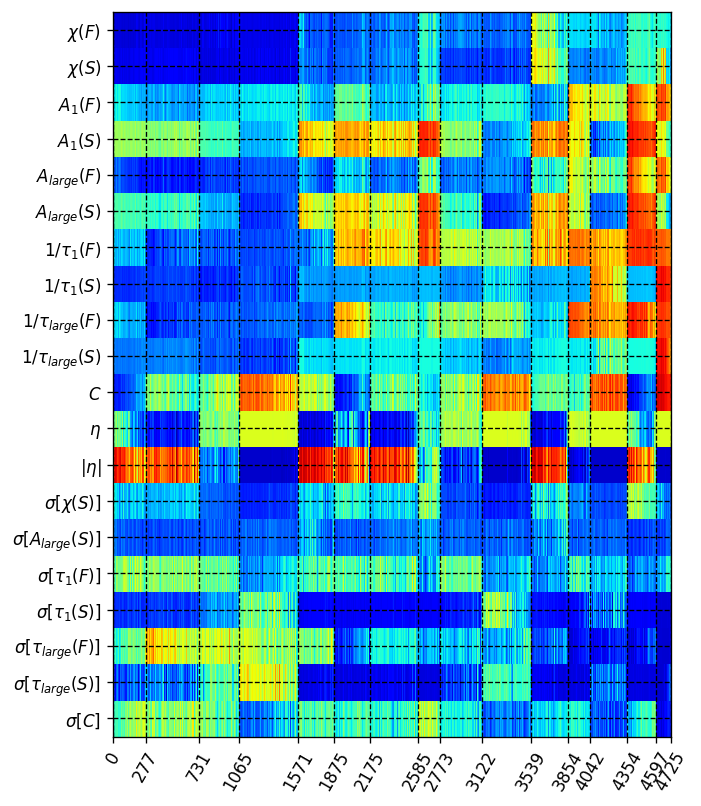

In [812]:
nc = 13

K = num_clusters[nc]
print(K)

id_itr = 4
cluster_id = km_objs[nc][id_itr].predict(pdata["data"].T)
reordered_data, id_sort, bds = hc.reorder_data(pdata["data"], rcluster_id, rsval)

plt.figure(figsize=(6, 8), dpi=120)
s_data = hc.hsmooth(reordered_data)
plt.imshow(s_data, aspect='auto', cmap="jet", interpolation="none")
plt.xticks([0] + bds, rotation=60)
plt.yticks(np.arange(s_data.shape[0]), labels=pdata["row_labels"])
plt.grid(True, lw=0.8, c='k', linestyle='--')
plt.show()

save to ./fig/silhouette_score_rank3_2023628.png


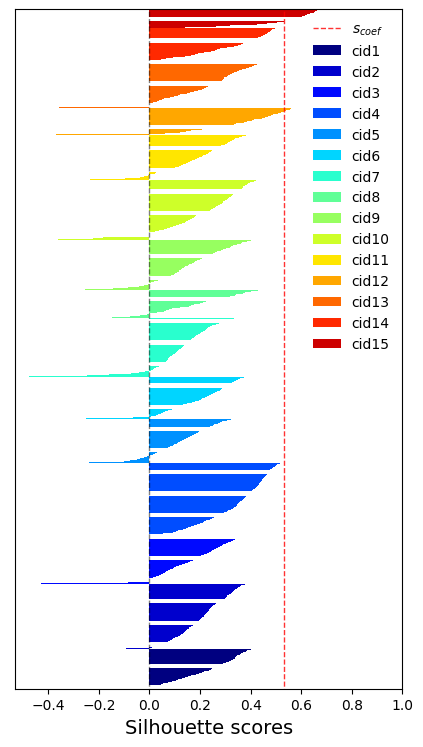

In [786]:
plt.figure(figsize=(5, 9), dpi=100)
hc.draw_silhouette(rsval, rcluster_id, scoeff=rscoeff, cmap="jet")
utils.save_fig("silhouette_score_rank3")
plt.show()

### Representative points & silhouette values

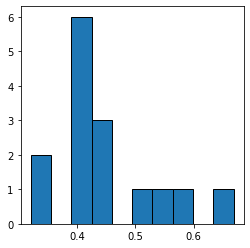

In [795]:
edges = [0] + bds
sval_best = [rsval[int(id_sort[n])] for n in edges[:-1]]

plt.figure(figsize=(4, 4))
plt.hist(sval_best, edgecolor='k')
plt.show()

### Check the relation between sval & distance from center

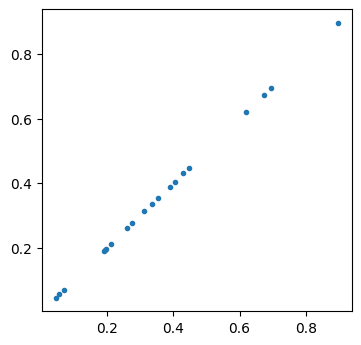

In [778]:
n = 10

plt.figure(figsize=(4,4), dpi=100)
plt.plot(np.average(reordered_data[:, edges[n]:edges[n+1]], axis=1), km_use.cluster_centers_[n, :], '.')
plt.show()

### Export points

In [837]:
# Save representative points
loc_points = []
sval_points = []

_, id_sort, bds = hc.reorder_data(pdata["data"], rcluster_id, rsval)

edges = [0] + bds
for n in range(K):
    id_pts = id_sort[edges[n]:edges[n+1]]
    loc_points.append([])
    sval_points.append([])
    for nid in id_pts:
        nid = int(nid)
        tag = pdata["col_names"][nid]
        nr = int(tag[0][2])
        nw = int(tag[0][5])
        nrow, ncol = tag[1:]
        
        loc_points[-1].append((nrow, ncol, nr, nw))
        sval_points[-1].append(rsval[nid])

with open("./data/cluster_repr_points_rank3.pkl", "wb") as fp:
    pkl.dump({"loc_points": loc_points,
              "sval_points": sval_points,
              "desc": "nrow, ncol, nrank, nw"}, fp)

## Draw stack images 

save to ./fig/ordered_cluster_id_2023629.png


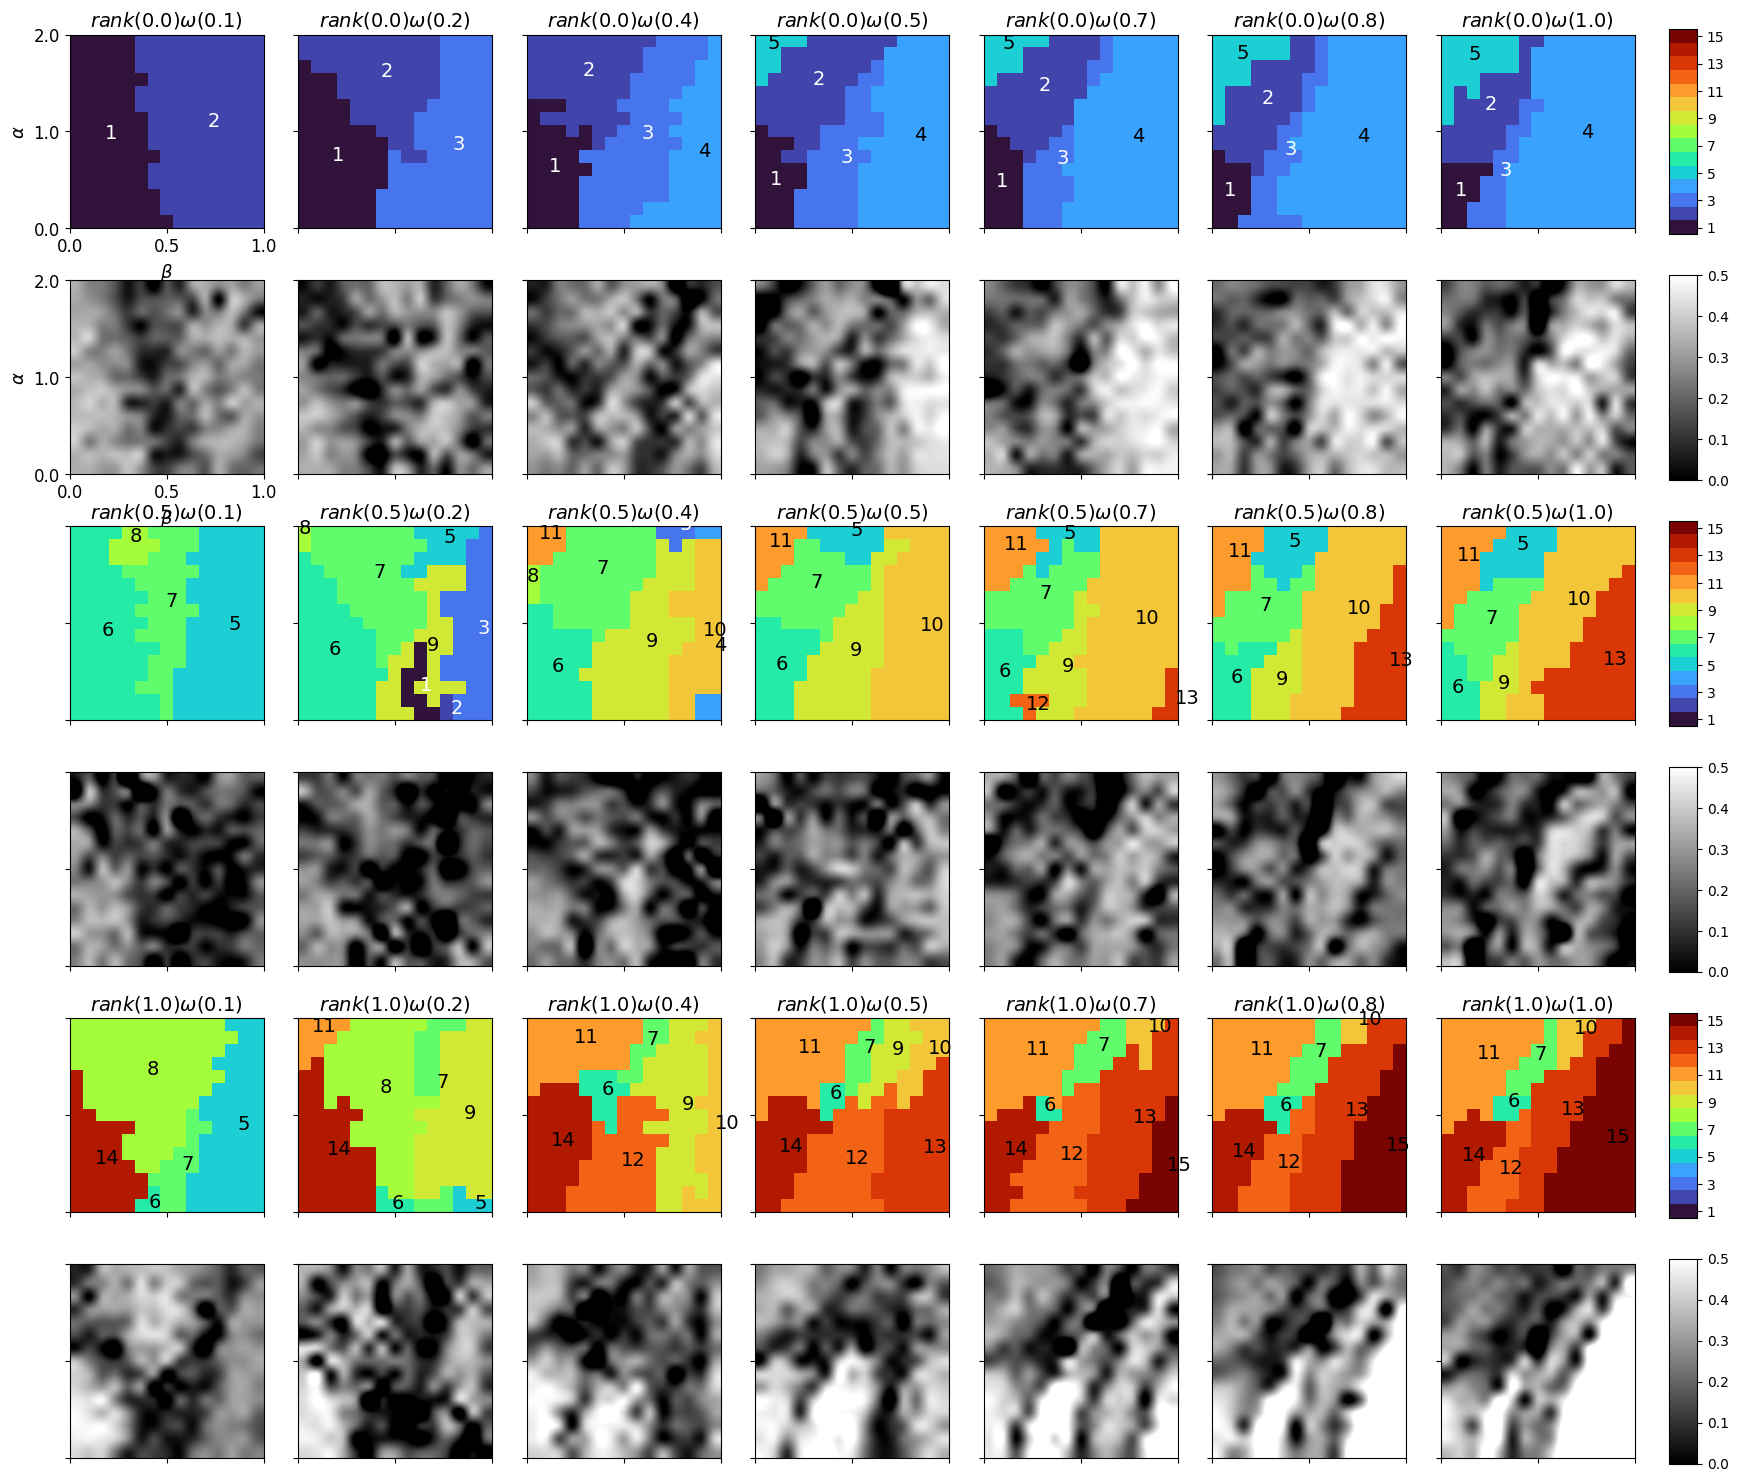

In [891]:
r_set = [0, 0.5, 1]
w_set = np.arange(0.1, 1.01, 0.15)
im_stacks = []

def set_label(nr, nc):
    if nr == 0 and nc == 0:
        plt.xticks([0, 0.5, 1], fontsize=12)
        plt.yticks([0, 0.5, 1], labels=["0.0", "1.0", "2.0"], fontsize=12)
        plt.xlabel(r"$\beta$", fontsize=13)
        plt.ylabel(r"$\alpha$", fontsize=13)
        
    else:
        plt.xticks([0, 0.5, 1], labels=["" for _ in range(3)], fontsize=12)
        plt.yticks([0, 0.5, 1], labels=["" for _ in range(3)])
        
col_names = pdata["col_names"]
# plt.figure(dpi=100, figsize=(20, 12))
fig, axs = plt.subplots(6, 8, dpi=100, figsize=(21, 19), gridspec_kw={"width_ratios": [0.98/7 for _ in range(7)] + [0.02]})
caxs = [[], []]
x = np.linspace(0, 1, 15)
y = np.linspace(0, 1, 15)

cmap = plt.get_cmap("turbo", K)
# cmap = plt.get_cmap("tab20c", K)

for nr in range(3):
    im_stacks.append([])
    for nw in range(7):
        im, _ = hc.construct_square_image("nr%dnp%d"%(nr, nw), rcluster_id, col_names)
        im_sval, _ = hc.construct_square_image("nr%dnp%d"%(nr, nw), rsval, col_names)
        im_stacks[-1].append(im)
        
        plt.axes(axs[2*nr, nw])
        # caxs[0] = plt.imshow(im, vmin=1, vmax=K, origin="lower", extent=[0, 1, 0, 1], cmap=cmap)
        caxs[0] = hc.show_sq_cluster(im, x=x, y=y, cmap=cmap, cth=3, vmin=1, vmax=K)
        plt.title(r"$rank(%.1f)\omega(%.1f)$"%(r_set[nr], w_set[nw]), fontsize=14)
        set_label(nr, nw)
        
        # if nr == 0 and nw == 0:
        #     plt.xlabel(r"$\beta$", fontsize=13)
        #     plt.ylabel(r"$\alpha$", fontsize=13)
        
        plt.axes(axs[2*nr+1, nw])
        caxs[1] = plt.imshow(im_sval, vmin=0, vmax=0.5, origin="lower", extent=[0, 1, 0, 1], cmap="gray", interpolation="spline16")
        set_label(nr, nw)
            
            
for n in range(6):
    plt.axes(axs[n][7])
    cbar = plt.colorbar(caxs[n%2], cax=axs[n][7])
    if n%2 == 0:
        ct = np.arange(1, K+1, 2).astype(int)
        ct_x = 0.5 + ct / K * (K-1)
        cbar.set_ticks(ct_x, labels=["%d"%(n) for n in ct])

utils.save_fig("ordered_cluster_id")
with open("./data/im_stacks_rank3.pkl", "wb") as fp:
    pkl.dump({"im_stacks": im_stacks,
              "rcluster_id": rcluster_id}, fp)

plt.show()

## Track feature change 

# Show the points on 2-D plane

In [16]:
with open("./data/rcluster_nrank3.pkl", "rb") as fp:
    buf = pkl.load(fp)
rcluster_id = buf["rcluster_id"]
# print(buf.keys())    

In [10]:
from sklearn.manifold import TSNE

np.random.seed(300)

tsne2d = TSNE(n_components=2, init="pca")
tsne_fit_2d = tsne2d.fit_transform(pdata["data"].copy().T)

C:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [11]:
def draw_with_tsne2d(**kwargs):
    plt.scatter(tsne_fit_2d[:, 0], tsne_fit_2d[:, 1], **kwargs)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Axis 1", fontsize=13)
    plt.ylabel("Axis 2", fontsize=13)
    for side in ['top','right','bottom','left']:
        plt.gca().spines[side].set_visible(False)

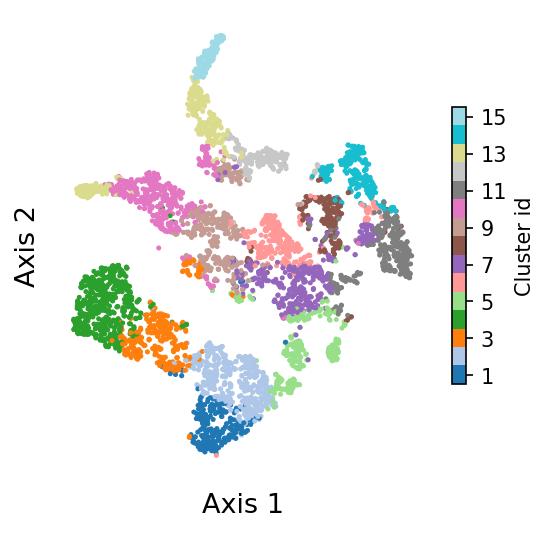

In [17]:
cmap = plt.get_cmap("tab20", K)

plt.figure(figsize=(4, 4), dpi=150)
draw_with_tsne2d(s=2, c=rcluster_id, cmap=cmap)
utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)
plt.show()

## Compare with previous result

In [639]:
with open("./data/rcluster.pkl", "rb") as fp:
    prev_cluster = pkl.load(fp)
    
# need to convert
c_prev = np.zeros_like(rcluster_id).astype(float)
nstack = 0
for n, tag in enumerate(pdata["col_names"]):
    nr = int(tag[0][2])
    if nr == 1:
        c_prev[n] = np.nan
        continue
    
    c_prev[n] = prev_cluster["rcluster_id"][nstack]
    nstack += 1
    
# calculate similarity between new and old clusters: how many points are overlapped
kold, knew = prev_cluster["K"], K
mat_overlap = np.zeros([knew+1, kold+1])
for id_n in range(knew+1):
    for id_o in range(kold+1):
        mat_overlap[id_n, id_o] = np.sum((rcluster_id==id_n) & (c_prev == id_o))
        
# relalign prev cluster id depending on 'mat_overlap'
c_prev_re = np.zeros_like(c_prev) * np.nan
cvt_table = [np.argmax(mat_overlap[:, n]) for n in range(1, kold+1)]
if len(np.unique(cvt_table)) != prev_cluster["K"]:
    raise ValueError("some clusters are overlapped")

print({i+1: cvt_table[i] for i in range(len(cvt_table))})    
for n in range(1, prev_cluster["K"]+1):
    c_prev_re[c_prev == n] = cvt_table[n-1]

# removed clusters
cid_rm = np.array([i for i in range(1, knew+1) if i not in cvt_table]).astype(int)

{1: 1, 2: 2, 3: 4, 4: 5, 5: 14, 6: 8, 7: 11, 8: 9, 9: 12, 10: 13, 11: 15}


save to ./fig/Cluster_compare_rank23_2023628.png


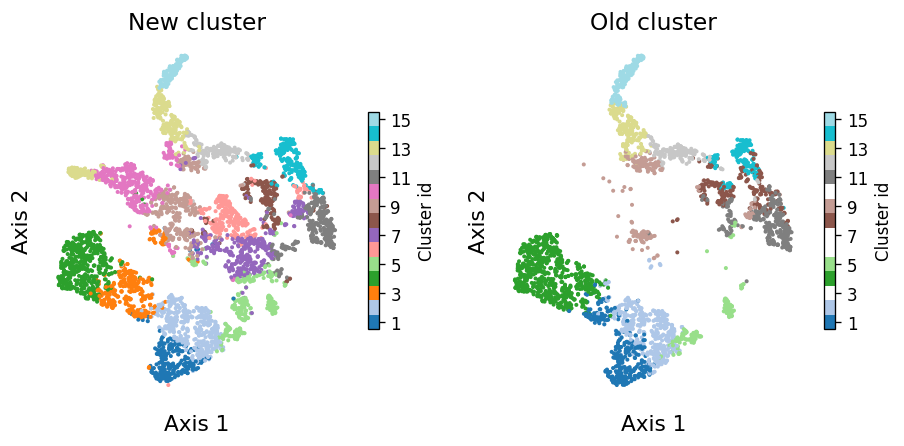

In [641]:
from copy import deepcopy

cmap = plt.get_cmap("tab20", K)
cmap_r = deepcopy(cmap)
cmap_r.colors[cid_rm-1,:] = 0

plt.figure(dpi=120, figsize=(9, 4))

plt.subplot(121)
draw_with_tsne2d(s=2, c=rcluster_id, cmap=cmap)
plt.title("New cluster", fontsize=14)
utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)

plt.subplot(122)
draw_with_tsne2d(s=2, c=c_prev_re, cmap=cmap_r)
plt.title("Old cluster", fontsize=14)
utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)

utils.save_fig("Cluster_compare_rank23")
plt.show()

## Show features 

In [19]:
def finder(target_row, row_names):
    return row_names.index(target_row)

### Chi 

save to ./fig\tSNE_chi_202372.png


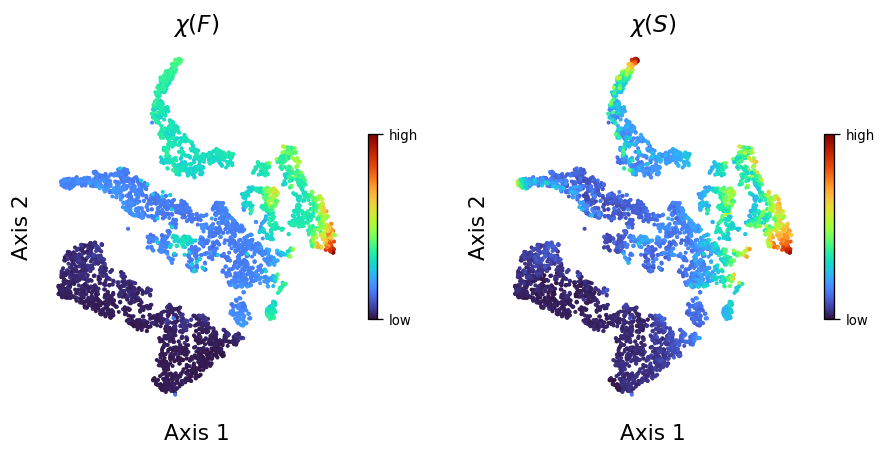

In [20]:
cmap = plt.get_cmap("turbo")

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("chi(1)", "chi(2)")):
    plt.subplot(1,2,n+1)
    
    nid = finder(tag, pdata["row_names"])
    draw_with_tsne2d(s=2, c=pdata["data"][nid, :], cmap=cmap, vmin=0, vmax=1)
    plt.title(pdata["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[0, 1])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
utils.save_fig("tSNE_chi")
plt.show()

### frequency - 1st peak 

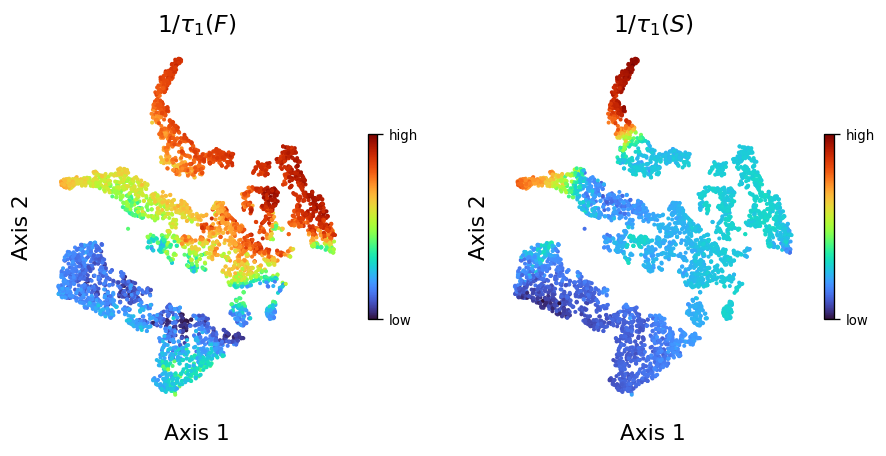

In [21]:
cmap = plt.get_cmap("turbo")

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("1/tau_1st(1)", "1/tau_1st(2)")):
    plt.subplot(1,2,n+1)
    
    nid = finder(tag, pdata["row_names"])
    draw_with_tsne2d(s=2, c=pdata["data"][nid, :], cmap=cmap, vmin=0, vmax=1)
    plt.title(pdata["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[0, 1])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)

# utils.save_fig("tSNE_frequency_1st")
plt.show()

### frequency - largest peak 

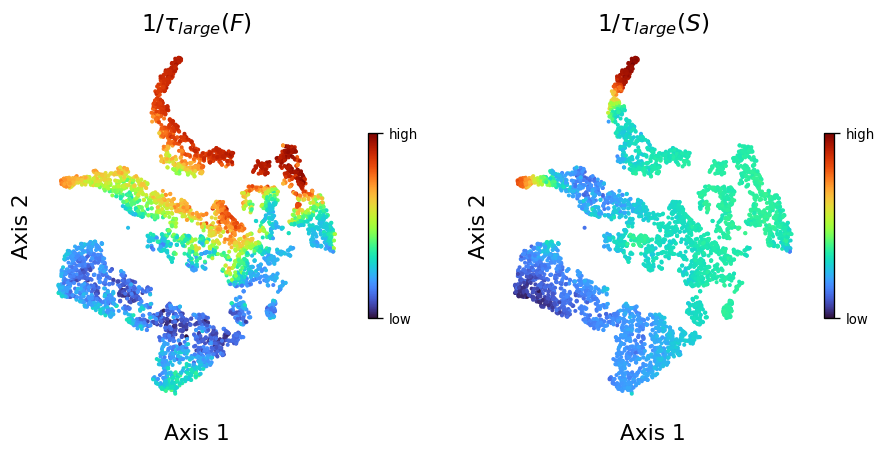

In [22]:
cmap = plt.get_cmap("turbo")

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("1/tau_large(1)", "1/tau_large(2)")):
    plt.subplot(1,2,n+1)
    
    nid = finder(tag, pdata["row_names"])
    draw_with_tsne2d(s=2, c=pdata["data"][nid, :], cmap=cmap, vmin=0, vmax=1)
    plt.title(pdata["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[0, 1])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)

# utils.save_fig("tSNE_frequency_large")
plt.show()

### frequency difference

save to ./fig/tSNE_delta_frequency_2023628.png


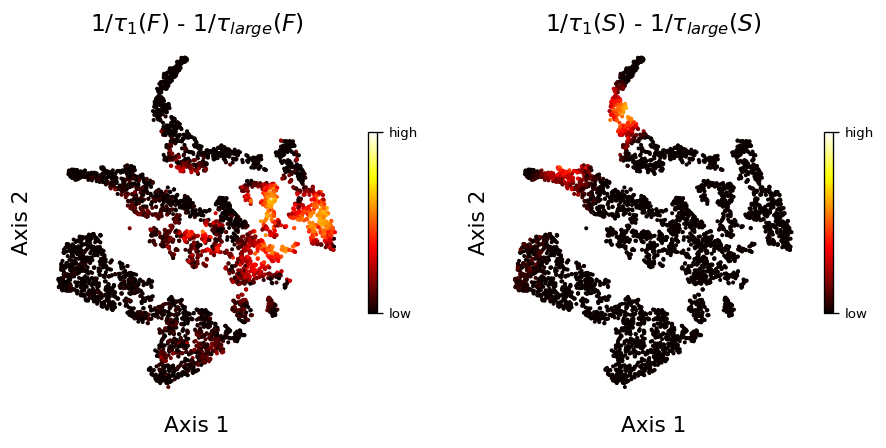

In [664]:
cmap = plt.get_cmap("hot")

plt.figure(dpi=120, figsize=(9, 4))
for n in range(1, 3):
    plt.subplot(1,2, n)
    nid1 = finder("1/tau_1st(%d)"%(n), pdata["row_names"])
    nid2 = finder("1/tau_large(%d)"%(n), pdata["row_names"])
    
    
    
    cdiff = pdata["data"][nid1, :] - pdata["data"][nid2, :]
    draw_with_tsne2d(s=2, c=cdiff, cmap=cmap, vmin=0, vmax=1)
    plt.title(pdata["row_labels"][nid1] + " - " + pdata["row_labels"][nid2],
              fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[0, 1])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
utils.save_fig("tSNE_delta_frequency")
plt.show()

## tSNE by considering cluster

In [53]:
from tqdm.notebook import trange

N = pdata["data"].shape[1]
dist = np.zeros([N, N])
for i in trange(N):
    v1 = pdata["data"][:, i]
    dist[i, :] += np.sqrt(np.sum((pdata["data"] - v1[:, np.newaxis])**2, axis=0))
    
    for j in range(i+1, N):
        if rcluster_id[i] != rcluster_id[j]:
            dist[i, j] += 1
            dist[j, i] += 1

  0%|          | 0/4725 [00:00<?, ?it/s]

In [54]:
np.random.seed(300)

tsne2d_d = TSNE(n_components=2, init="pca")
tsne_fit_2d_d = tsne2d.fit_transform(dist.copy())

C:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jungyoung\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


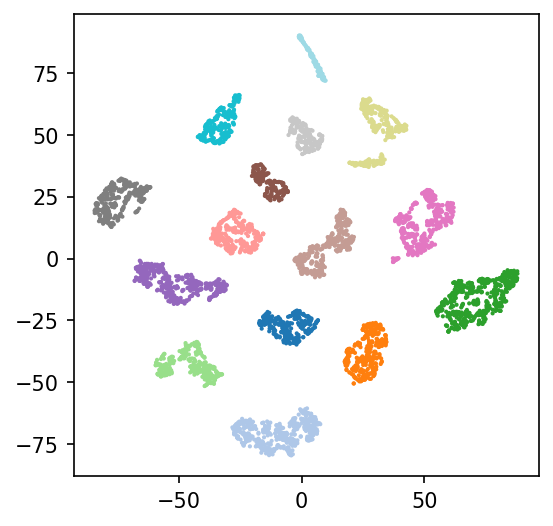

In [55]:
cmap = plt.get_cmap("tab20", K)

plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(tsne_fit_2d_d[:, 0], tsne_fit_2d_d[:, 1], s=1, c=rcluster_id, cmap=cmap)
# draw_with_tsne2d(s=2, c=rcluster_id, cmap=cmap)
# utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)
plt.show()

### Total population

In [ ]:
# 

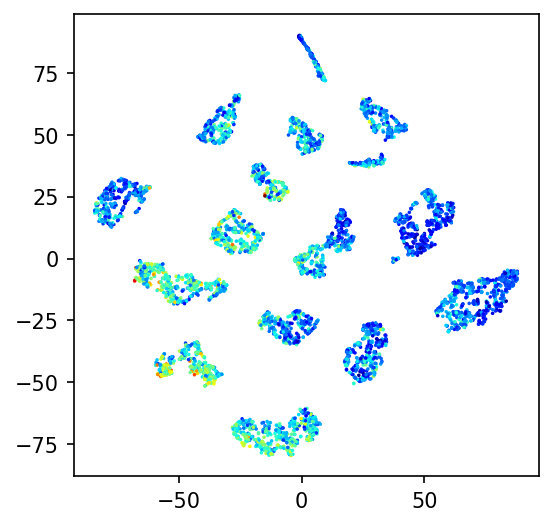

In [59]:
nid = finder("ac2p_large_std(0)", pdata["removed"]["row_names"])

plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(tsne_fit_2d_d[:, 0], tsne_fit_2d_d[:, 1], s=0.5, c=pdata["removed"]["data"][nid, :], cmap="jet")
# draw_with_tsne2d(s=2, c=rcluster_id, cmap=cmap)
# utils.draw_categorical_colorbar(n_category=K, label="Cluster id", shrink=0.6)
plt.show()